
Viscoplastic thermal convection in a 2-D square box
=======

Benchmarks from Tosi et al. 2015
--------



This notebook generates models from the <a name="ref-1"/>[(Tosi et al., 2015)](#cite-tosi2015community) in Underworld2. The Underworld2 results are compared to the model run on Fenics. Input files for the Fenics models were provided by Petra Maierova.

This example uses the RT PIC solver with classic and nearest neighbour


References
====

<a name="cite-tosi2015community"/><sup>[^](#ref-1) </sup>Tosi, Nicola and Stein, Claudia and Noack, Lena and H&uuml;ttig, Christian and Maierov&aacute;, Petra and Samuel, Henri and Davies, DR and Wilson, CR and Kramer, SC and Thieulot, Cedric and others. 2015. _A community benchmark for viscoplastic thermal convection in a 2-D square box_.



Load python functions needed for underworld. Some additional python functions from os, math and numpy used later on.

In [4]:
import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt
import matplotlib.pyplot as pyplot
import time
import numpy as np
import os

Set physical constants and parameters, including the Rayleigh number (*RA*). 

In [5]:
ETA_T = 1e5
newvisc = math.exp(math.log(ETA_T)*0.64)
newvisc

1584.8931924611143

In [6]:
case_dict = {}
case_dict[1] = {}
case_dict[1]['ETA_Y'] = 1.
case_dict[1]['YSTRESS'] = 1.

case_dict[2] = {}
case_dict[2]['ETA_Y'] = 1.
case_dict[2]['YSTRESS'] = 1.*newvisc

case_dict[3] = {}
case_dict[3]['ETA_Y'] = 10.

case_dict[4] = {}
case_dict[4]['ETA_Y'] = 10.
case_dict[4]['YSTRESS'] = 1.

case_dict[5] = {}
case_dict[5]['ETA_Y'] = 10.
case_dict[5]['YSTRESS'] = 4.

In [7]:
CASE = 2 # select identifier of the testing case (1-5)

In [8]:
RA  = 1e2        # Rayleigh number
TS  = 0          # surface temperature
TB  = 1          # bottom boundary temperature (melting point)
ETA_Y = case_dict[CASE]['ETA_Y']
ETA0 = 1e-3*newvisc
TMAX = 3.0
IMAX = 1000
YSTRESS = case_dict[CASE]['YSTRESS']

Alternatively, use a reference viscosity identical to Crameri and Tackley, i.e. normalised at 0.64.
In this case the Rayligh number would go to:

In [9]:
math.exp(math.log(10**5)*0.64)

1584.8931924611143

In [10]:
#RA2/RA == newvisc

In [11]:
RA2 = RA *math.exp(math.log(10**5)*0.64)
print('new Rayleigh number would be: ' + str(RA2))

new Rayleigh number would be: 158489.319246


In [15]:
print(str(RA2), str(ETA0), str(YSTRESS))

('158489.319246', '1.58489319246', '1584.89319246')


Simulation parameters. Resolution in the horizontal (*Xres*) and vertical (*Yres*) directions.

In [13]:
Xres, Yres = 64, 64
dim = 2          # number of spatial dimensions

Select which case of viscosity from Tosi et al (2015) to use. Adjust the yield stress to be =1 for cases 1-4, or between 3.0 and 5.0 (in increments of 0.1) in case 5.

Set output file and directory for results

In [10]:
outputPath = 'TosiOutput/'
imagePath = 'TosiOutput/images'
filePath = 'TosiOutput/files'
dbPath = 'TosiOutput/gldbs'
#outputFile = 'results_case' + str(CASE) + '.dat'
outputFile = 'RA_check_' + str(CASE) + '.dat'


# make directories if they don't exist
if not os.path.isdir(outputPath):
    os.makedirs(outputPath)
if not os.path.isdir(imagePath):
    os.makedirs(imagePath)
if not os.path.isdir(dbPath):
    os.makedirs(dbPath)
if not os.path.isdir(filePath):
    os.makedirs(filePath)

Create mesh objects. These store the indices and spatial coordiates of the grid points on the mesh.

In [11]:
elementMesh = uw.mesh.FeMesh_Cartesian( elementType=("Q1/dQ0"), 
                                         elementRes=(Xres, Yres), 
                                           minCoord=(0.,0.), 
                                           maxCoord=(1.,1.)  )
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh 

Create Finite Element (FE) variables for the velocity, pressure and temperature fields. The last two of these are scalar fields needing only one value at each mesh point, while the velocity field contains a vector of *dim* dimensions at each mesh point.

In [12]:
velocityField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=dim )
pressureField    = uw.fevariable.FeVariable( feMesh=constantMesh, nodeDofCount=1 )
temperatureField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1 )

Create some dummy fevariables for doing top and bottom boundary calculations.

In [13]:
topField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1)
bottomField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1)

topField.data[:] = 0.
bottomField.data[:] = 0.

# lets ensure temp boundaries are still what we want 
# on the boundaries
for index in linearMesh.specialSets["MinJ_VertexSet"]:
    bottomField.data[index] = 1.
for index in linearMesh.specialSets["MaxJ_VertexSet"]:
    topField.data[index] = 1.

#ICs and BCs

In [14]:
# Initialise data.. Note that we are also setting boundary conditions here
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
temperatureField.data[:] = 0.

# Setup temperature initial condition via numpy arrays
A = 0.01
#Note that width = height = 1
tempNump = temperatureField.data
for index, coord in enumerate(linearMesh.data):
    pertCoeff = (1- coord[1]) + A*math.cos( math.pi * coord[0] ) * math.sin( math.pi * coord[1] )
    tempNump[index] = pertCoeff;
    

In [15]:
# Get the actual sets 
#
#  HJJJJJJH
#  I      I
#  I      I
#  I      I
#  HJJJJJJH
#  
#  Note that H = I & J 

# Note that we use operator overloading to combine sets
IWalls = linearMesh.specialSets["MinI_VertexSet"] + linearMesh.specialSets["MaxI_VertexSet"]
JWalls = linearMesh.specialSets["MinJ_VertexSet"] + linearMesh.specialSets["MaxJ_VertexSet"]

In [16]:
# Now setup the dirichlet boundary condition
# Note that through this object, we are flagging to the system 
# that these nodes are to be considered as boundary conditions. 
# Also note that we provide a tuple of sets.. One for the Vx, one for Vy.
freeslipBC = uw.conditions.DirichletCondition(     variable=velocityField, 
                                              nodeIndexSets=(IWalls,JWalls) )

# also set dirichlet for temp field
tempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              nodeIndexSets=(JWalls,) )

In [17]:
# Set temp boundaries 
# on the boundaries
for index in linearMesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = TB
for index in linearMesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = TS

#Material properties


In [18]:
#Make variables required for plasticity

secinvCopy = fn.tensor.second_invariant( 
                    fn.tensor.symmetric( 
                        velocityField.gradientFn ))


In [19]:
coordinate = fn.input()

In [20]:
newvisc

1584.8931924611143

In [21]:
#Remember to use floats everywhere when setting up functions

#Linear viscosities
#viscosityl1 = fn.math.exp(math.log(ETA_T)*-1*temperatureField)
#viscosityl1 = fn.math.exp((math.log(ETA_T)*-1*temperatureField) + (math.log(ETA_T)*-1*0.64))
viscosityl1 = newvisc*fn.math.exp(math.log(ETA_T)*-1*temperatureField)

viscosityl2 = fn.math.exp((math.log(ETA_T)*-1*temperatureField) + (1.-coordinate[1])*math.log(ETA_Y))

viscosityFn1 = viscosityl1 #This one always gets passed to the first velcotity solve

#Von Mises effective viscosity
viscosityp = ETA0 + YSTRESS/(secinvCopy/math.sqrt(0.5)) #extra factor to account for underworld second invariant form


if CASE == 1:
    viscosityFn2 = viscosityFn1
elif CASE == 2:
    viscosityFn2 = 2./(1./viscosityl1 + 1./viscosityp)
elif CASE == 3:
    viscosityFn2 = viscosityl2
else:
    viscosityFn2 = 2./(1./viscosityl2 + 1./viscosityp)


Set up simulation parameters and functions
====

Here the functions for density, viscosity etc. are set. These functions and/or values are preserved for the entire simulation time. 

In [22]:
densityFn = RA2*temperatureField

# define our vertical unit vector using a python tuple (this will be automatically converted to a function)
z_hat = ( 0.0, 1.0 )

# now create a buoyancy force vector using the density (FEvariable) and the vertical unit vector. 
# The result from which will also be a FEvariable.
buoyancyFn = densityFn * z_hat

Build the Stokes system, solvers, advection-diffusion
------

Setup linear Stokes system to get the initial velocity.

In [23]:
#We first set up a l
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
#                              viscosityFn=viscosityFn1, 
                              viscosityFn=fn.exception.SafeMaths(viscosityFn1), 
                              bodyForceFn=buoyancyFn)

We do one solve with linear viscosity to get the initial strain rate invariant. This solve step also calculates a 'guess' of the the velocity field based on the linear system, which is used later in the non-linear solver.

In [24]:
stokesPIC.solve()

In [25]:
# Setup the Stokes system again, now with linear or nonlinear visocity viscosity.
stokesPIC2 = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              viscosityFn=fn.exception.SafeMaths(viscosityFn2), 
                              bodyForceFn=buoyancyFn )

In [26]:
solver = uw.systems.Solver(stokesPIC2) # altered from PIC2

Solve for initial pressure and velocity using a quick non-linear Picard iteration


In [27]:
solver.solve(nonLinearIterate=True)

Create an advective-diffusive system
=====

Setup the system in underworld by flagging the temperature and velocity field variables.

In [28]:
# Create advdiff system
advDiff = uw.systems.AdvectionDiffusion( temperatureField, velocityField, diffusivity=1., conditions=[tempBC,] )


Metrics for benchmark
=====

Define functions to be used in the time loop. For cases 1-4, participants were asked to report a number of diagnostic quantities to be measured after reaching steady state:

* Average temp... $$  \langle T \rangle  = \int^1_0 \int^1_0 T \, dxdy $$
* Top and bottom Nusselt numbers... $$N = \int^1_0 \frac{\partial T}{\partial y} \rvert_{y=0/1} \, dx$$
* RMS velocity over the whole domain, surface and max velocity at surface
* max and min viscosity over the whole domain
* average rate of work done against gravity...$$\langle W \rangle = \int^1_0 \int^1_0 T u_y \, dx dy$$
* and the average rate of viscous dissipation...$$\langle \Phi \rangle = \int^1_0 \int^1_0 \tau_{ij} \dot \epsilon_{ij} \, dx dy$$

* In steady state, if thermal energy is accurately conserved, the difference between $\langle W \rangle$ and $\langle \Phi \rangle / Ra$ must vanish, so also reported is the percentage error: 

$$ \delta = \frac{\lvert \langle W \rangle - \frac{\langle \Phi \rangle}{Ra} \rvert}{max \left(  \langle W \rangle,  \frac{\langle \Phi \rangle}{Ra}\right)} \times 100% $$

In [29]:
#Setup some Integrals. We want these outside the main loop...
tempint = uw.utils.Integral(temperatureField, linearMesh)
areaint = uw.utils.Integral(1.,linearMesh)

v2int = uw.utils.Integral(fn.math.dot(velocityField,velocityField), linearMesh)
topareaint = uw.utils.Integral((topField*1.),linearMesh)

dwint = uw.utils.Integral(temperatureField*velocityField[1], linearMesh)

secinv = fn.tensor.second_invariant(
                    fn.tensor.symmetric(
                        velocityField.gradientFn ))

sinner = fn.math.dot(secinv,secinv)
vdint = uw.utils.Integral((4.*viscosityFn2*sinner), linearMesh)

In [30]:
def avg_temp():
    return tempint.integrate()[0]/areaint.integrate()[0]

#This one gets cleaned up when Surface integrals are available
def nusselt(temp_field, mesh):
    #surface_Tgradient = -temp_field.gradientFn.evaluate(mesh.specialSets["MaxJ_VertexSet"]).T[1]
    #basalT = temp_field.evaluate(mesh.specialSets["MinJ_VertexSet"])
    #nusselt = surface_Tgradient.mean() / basalT.mean()
    #return nusselt
    return 0.

def rms():
    return math.sqrt(v2int.integrate()[0]/areaint.integrate()[0])


#This one gets cleaned up when Surface integrals are available
def rms_surf():
    xvelocityField = fn.math.dot(velocityField,np.array([1.,0.]))
    return math.sqrt(v2int.integrate()[0]/topareaint.integrate()[0])

def max_vx_surf(velfield, mesh):
    vuvelxfn = fn.view.min_max(velfield[0])
    vuvelxfn.evaluate(mesh.specialSets["MaxJ_VertexSet"])
    return vuvelxfn.max_global()

def gravwork(workfn):
    return workfn.integrate()[0]

def viscdis(vdissfn):
    return vdissfn.integrate()[0]

def visc_extr(viscfn):
    vuviscfn = fn.view.min_max(viscfn)
    vuviscfn.evaluate(linearMesh)
    return vuviscfn.max_global(), vuviscfn.min_global()

In [31]:
#Fields for saving data / fields

rmsField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1)
rmsfn = fn.math.sqrt(fn.math.dot(velocityField,velocityField))
rmsdata = rmsfn.evaluate(linearMesh)
rmsField.data[:] = rmsdata 

viscField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1)
viscdata = viscosityFn2.evaluate(linearMesh)
viscField.data[:] = viscdata


stressField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1)
srtdata = fn.tensor.second_invariant( 
                    fn.tensor.symmetric( 
                        velocityField.gradientFn ))
rostfield = srtdata.evaluate(linearMesh)
stressinv = 2*viscdata*rostfield[:]
stressField.data[:] = stressinv

Main simulation loop
=======

The main time stepping loop begins here. Before this the time and timestep are initialised to zero and the output statistics arrays are set up. Also the frequency of outputting basic statistics to the screen is set in steps_output.


In [32]:
realtime = 0.
step = 0
timevals = [0.]
vrmsvals = []
steps_end = 1000
steps_output = 10
steps_outtoscreen = 50
steps_outtoscreen = max(steps_outtoscreen,1)
steps_output = min(steps_output,steps_end/10)
steps_output = max(steps_output,1)

In [33]:
# initialise timer for computation
start = time.clock()
# setup summary output file (name above)
f_o = open(outputPath+outputFile, 'w')
# Perform steps
#while realtime < 3:
while step < 700:
    #Enter non-linear loop
    solver.solve(nonLinearIterate=True)
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    advDiff.integrate(dt)
    # Increment
    realtime += dt
    step += 1
    timevals.append(realtime)
    # Calculate the Metrics, only on 1 of the processors:
    Avg_temp = avg_temp()
    Rms = rms()
    Rms_surf = rms_surf()
    Max_vx_surf = max_vx_surf(velocityField, linearMesh)
    Gravwork = gravwork(dwint)
    Viscdis = viscdis(vdint)
    nu1, nu0 = nusselt(temperatureField, linearMesh), nusselt(temperatureField, linearMesh)
    etamax, etamin = visc_extr(viscosityFn2)
    # output to summary text file
    if uw.rank()==0:
        f_o.write((11*'%-15s ' + '\n') % (realtime, Viscdis, nu0, nu1, Avg_temp, Rms,Rms_surf,Max_vx_surf,Gravwork, etamax, etamin))
    # output image to file
    if step % steps_output == 0:
        print 'step =',step, 'dt =', dt
        ##Files to save
        #Temp
        fnametemp = "temperatureField" + "_" + str(CASE) + "_" + str(step) + ".hdf5"
        fullpath = os.path.join(outputPath + "files/" + fnametemp)
        temperatureField.save(fullpath)
        #RMS
        fnamerms = "rmsField" + "_" + str(CASE) + "_" + str(step) + ".hdf5"
        fullpath = os.path.join(outputPath + "files/" + fnamerms)
        rmsField.save(fullpath)
        #Viscosity
        fnamevisc = "viscField" + "_" + str(CASE) + "_" + str(step) + ".hdf5"
        fullpath = os.path.join(outputPath + "files/" + fnamevisc)
        viscField.save(fullpath)
        #Stress
        fnamestress = "stressField" + "_" + str(CASE) + "_" + str(step) + ".hdf5"
        fullpath = os.path.join(outputPath + "files/" + fnamestress)
        stressField.save(fullpath)
f_o.close()

step = 10 dt = 6.103515625e-05
step = 20 dt = 6.103515625e-05
step = 30 dt = 6.103515625e-05
step = 40 dt = 6.103515625e-05
step = 50 dt = 4.54252461411e-05
step = 60 dt = 3.43951973143e-05
step = 70 dt = 2.70468942994e-05
step = 80 dt = 2.18724557172e-05
step = 90 dt = 1.81457448231e-05
step = 100 dt = 1.5415574686e-05
step = 110 dt = 1.33786067566e-05
step = 120 dt = 1.18642265036e-05
step = 130 dt = 1.07027761052e-05
step = 140 dt = 9.8490206951e-06
step = 150 dt = 9.21126310294e-06
step = 160 dt = 8.7442686509e-06
step = 170 dt = 8.42321314535e-06
step = 180 dt = 8.21624339865e-06
step = 190 dt = 7.99677648477e-06
step = 200 dt = 7.7505580814e-06
step = 210 dt = 7.60358368696e-06
step = 220 dt = 7.52911428783e-06
step = 230 dt = 7.50734842956e-06
step = 240 dt = 7.52247159253e-06
step = 250 dt = 7.5619841412e-06
step = 260 dt = 7.61659436332e-06
step = 270 dt = 7.6768189695e-06
step = 280 dt = 7.7354575597e-06
step = 290 dt = 7.78404026494e-06
step = 300 dt = 7.8267215933e-06
step 

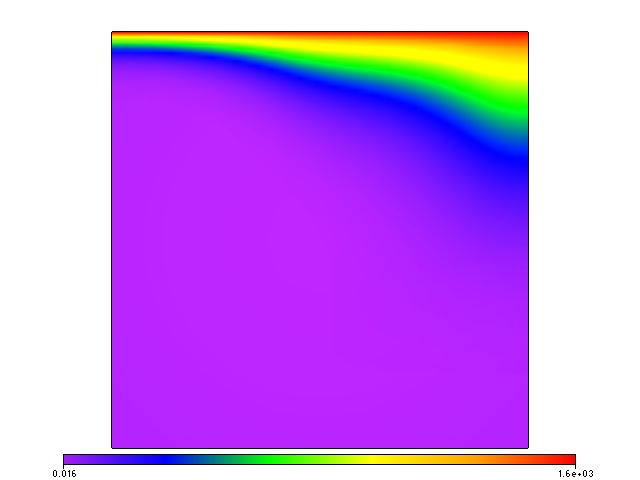

In [37]:
fig1 = plt.Figure()
#fig1.Surface(buoyancyFn[1], elementMesh)
fig1.Surface(viscosityl1, elementMesh)
#fig1.Points( swarm=gSwarm, colourVariable=viscVariable , pointSize=3.0)
#fig1.VectorArrows(velocityField, linearMesh, lengthScale=0.02)
fig1.show()

In [35]:
system = buoyancyFn[1]/viscosityl1

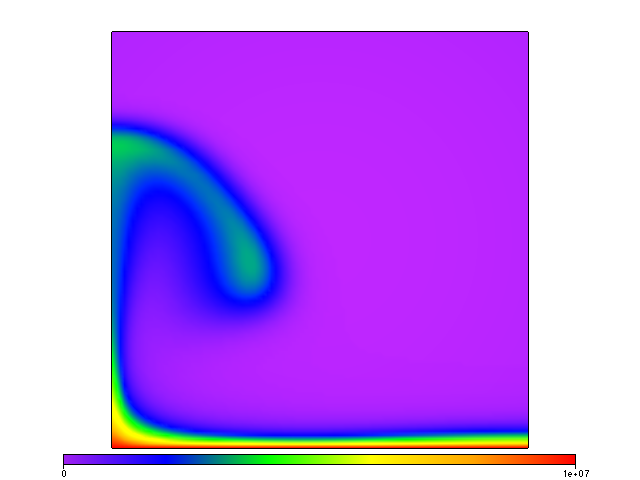

In [36]:
fig1 = plt.Figure()
#fig1.Surface(buoyancyFn[1], elementMesh)
fig1.Surface(system, elementMesh)
#fig1.Points( swarm=gSwarm, colourVariable=viscVariable , pointSize=3.0)
#fig1.VectorArrows(velocityField, linearMesh, lengthScale=0.02)
fig1.show()

In [37]:
ssdata = system.evaluate(linearMesh)
print(ssdata.min(), ssdata.max(), ssdata.mean())

(0.0, 10000000.000000004, 876365.97808960499)


In [39]:
viscdata = viscosityl1.evaluate(linearMesh)

In [40]:
viscdata.max()/viscdata.min()

100000.00000000003

In [41]:
newvisc

1584.8931924611143

In [42]:
0.0, 10000000.000000004, 865006.02971100481

(0.0, 10000000.000000004, 865006.0297110048)